# CLIP-Style Zero-Shot Classification on Caltech101
## (Training Only the Image Encoder, Frozen BERT Text Encoder)

Train a CLIP-style zero-shot classifier on Caltech-101, training only the image encoder (vit_small_patch16_224.augreg_in21k_ft_in1k) while keeping the BERT text encoder frozen. After training, we evaluate zero-shot performance on the test split.

In [9]:
!pip install torch torchvision transformers timm tqdm --quiet

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import Caltech101
from transformers import BertTokenizer, BertModel
import timm
import numpy as np
from tqdm import tqdm
import random
from collections import defaultdict
import gc
import os

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
### Updated Step 4: Dataset Loading + Split (No Change to Transform, Just Added Print)
#```python
import os  # Add this to imports if not already there

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # Fixes grayscale
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

full_dataset = Caltech101(root='./data', download=True, transform=transform)

# Reproducible split
random.seed(42)
indices_per_class = defaultdict(list)
for idx in range(len(full_dataset)):
    _, label = full_dataset[idx]  # label is int 0-100
    indices_per_class[label].append(idx)

train_indices = []
test_indices = []
for label, idxs in indices_per_class.items():
    random.shuffle(idxs)
    n_train = min(30, len(idxs))
    train_indices.extend(idxs[:n_train])
    test_indices.extend(idxs[n_train:])

trainset = Subset(full_dataset, train_indices)
testset  = Subset(full_dataset, test_indices)

print(f"Train samples: {len(trainset)}")
print(f"Test samples:  {len(testset)}")
print(f"Number of classes: {len(indices_per_class)}")  # 101

batch_size = 128
accumulation_steps = 2

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Train samples: 3030
Test samples:  5647
Number of classes: 101


In [16]:
# Get the exact category names in the correct label order (sorted as torchvision does)
categories_path = os.path.join('./data', 'caltech101', '101_ObjectCategories')
categories = [d for d in os.listdir(categories_path)
              if os.path.isdir(os.path.join(categories_path, d)) and d != 'BACKGROUND_Google']
categories.sort()  # Critical: matches torchvision's label assignment

# Convert to natural prompt-friendly names (lowercase, underscore → space)
class_names = [name.lower().replace('_', ' ') for name in categories]

print(f"Number of classes: {len(class_names)}")  # Should be 101
print("Example class names:", class_names[:10])   # e.g., ['faces', 'faces easy', 'leopards', ...]

# Templates remain the same
templates = [
    "a photo of a {}.",
    "a photo of a small {}.",
    "a photo of the {}.",
    "an image of a {}.",
    "an image of the {}."
]

Number of classes: 101
Example class names: ['faces', 'faces easy', 'leopards', 'motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass']


In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_model = BertModel.from_pretrained('bert-base-uncased').to(device)
text_model.eval()
for param in text_model.parameters():
    param.requires_grad = False

def encode_texts(prompts):
    inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = text_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS]
    return embeddings

text_emb_list = []
for template in templates:
    prompts = [template.format(c) for c in class_names]  # Uses dynamic class_names
    emb = encode_texts(prompts)
    text_emb_list.append(emb)

text_embeddings = torch.stack(text_emb_list).mean(dim=0)  # (101, 768)
text_embeddings = F.normalize(text_embeddings, dim=-1)
print("Text embeddings shape:", text_embeddings.shape)

# Cleanup
del text_model, tokenizer
gc.collect()
torch.cuda.empty_cache()

Text embeddings shape: torch.Size([101, 768])


In [20]:
image_model = timm.create_model(
    'vit_small_patch16_224.augreg_in21k_ft_in1k',
    pretrained=True,
    num_classes=0  # Raw features
).to(device)

projection = nn.Linear(384, 768).to(device)
logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [21]:
optimizer = torch.optim.AdamW(
    list(image_model.parameters()) + list(projection.parameters()) + [logit_scale],
    lr=5e-5,
    weight_decay=0.01
)

scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

/tmp/ipython-input-2477254637.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [23]:
# Updated Training Loop + Per-Epoch Accuracy Monitoring
### New/Updated Step 9.5: Zero-Shot Evaluation Function (Place BEFORE the training loop)

@torch.no_grad()
def zero_shot_accuracy(loader, desc="Test"):
    image_model.eval()
    projection.eval()
    correct = 0
    total = 0
    for images, labels in tqdm(loader, desc=desc, leave=False):
        images, labels = images.to(device), labels.to(device)
        with torch.cuda.amp.autocast():
            img_feat = image_model(images)
            img_feat = projection(img_feat)
            img_feat = F.normalize(img_feat, dim=-1)
            logits = logit_scale.exp() * img_feat @ text_embeddings.T
            preds = logits.argmax(dim=-1)  # Fixed typo here
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    image_model.train()  # Switch back to train mode
    projection.train()
    return 100.0 * correct / total

In [24]:
epochs = 30  # You can increase to 50 later

for epoch in range(epochs):
    image_model.train()
    projection.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for i, (images, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} [Train]")):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            img_feat = image_model(images)
            img_feat = projection(img_feat)
            img_feat = F.normalize(img_feat, dim=-1)
            logits = logit_scale.exp() * img_feat @ text_embeddings.T
            loss = F.cross_entropy(logits, labels) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(trainloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    scheduler.step()
    avg_loss = total_loss / len(trainloader)

    # --- Per-epoch accuracy ---
    train_acc = zero_shot_accuracy(trainloader, desc=f"Epoch {epoch+1} [Train Acc]")

    print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f} - Train Acc: {train_acc:.2f}%")

    # Test accuracy every 5 epochs (or at the end)
    if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
        test_acc = zero_shot_accuracy(testloader, desc=f"Epoch {epoch+1} [Test Acc]")
        print(f"*** Epoch {epoch+1}/{epochs} - Test Acc: {test_acc:.2f}% ***")

    if (epoch + 1) % 5 == 0:
        torch.cuda.empty_cache()

Epoch 1/30 [Train]:   0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipython-input-1295756757.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Train Acc]:   0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipython-input-3113475244.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 - Avg Loss: 4.5189 - Train Acc: 25.35%


Epoch 2/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch 2/30 - Avg Loss: 4.2772 - Train Acc: 41.09%


Epoch 3/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Epoch 3/30 - Avg Loss: 4.0599 - Train Acc: 44.55%


Epoch 4/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch 4/30 - Avg Loss: 3.8615 - Train Acc: 48.42%


Epoch 5/30 [Train]: 100%|██████████| 24/24 [00:10<00:00,  2.22it/s]


Epoch 5/30 - Avg Loss: 3.6878 - Train Acc: 54.95%


*** Epoch 5/30 - Test Acc: 59.50% ***


Epoch 6/30 [Train]: 100%|██████████| 24/24 [00:10<00:00,  2.24it/s]


Epoch 6/30 - Avg Loss: 3.5363 - Train Acc: 60.53%


Epoch 7/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


Epoch 7/30 - Avg Loss: 3.4081 - Train Acc: 66.50%


Epoch 8/30 [Train]: 100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


Epoch 8/30 - Avg Loss: 3.3016 - Train Acc: 71.19%


Epoch 9/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


Epoch 9/30 - Avg Loss: 3.2130 - Train Acc: 75.71%


Epoch 10/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.07it/s]


Epoch 10/30 - Avg Loss: 3.1387 - Train Acc: 79.67%


*** Epoch 10/30 - Test Acc: 73.83% ***


Epoch 11/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Epoch 11/30 - Avg Loss: 3.0772 - Train Acc: 82.64%


Epoch 12/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]


Epoch 12/30 - Avg Loss: 3.0246 - Train Acc: 85.05%


Epoch 13/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]


Epoch 13/30 - Avg Loss: 2.9788 - Train Acc: 86.63%


Epoch 14/30 [Train]: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]


Epoch 14/30 - Avg Loss: 2.9420 - Train Acc: 87.33%


Epoch 15/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


Epoch 15/30 - Avg Loss: 2.9102 - Train Acc: 87.79%


*** Epoch 15/30 - Test Acc: 77.88% ***


Epoch 16/30 [Train]: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]


Epoch 16/30 - Avg Loss: 2.8828 - Train Acc: 89.01%


Epoch 17/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]


Epoch 17/30 - Avg Loss: 2.8586 - Train Acc: 89.97%


Epoch 18/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


Epoch 18/30 - Avg Loss: 2.8409 - Train Acc: 90.66%


Epoch 19/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]


Epoch 19/30 - Avg Loss: 2.8243 - Train Acc: 90.69%


Epoch 20/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.18it/s]


Epoch 20/30 - Avg Loss: 2.8103 - Train Acc: 91.32%


*** Epoch 20/30 - Test Acc: 79.42% ***


Epoch 21/30 [Train]: 100%|██████████| 24/24 [00:10<00:00,  2.19it/s]


Epoch 21/30 - Avg Loss: 2.7996 - Train Acc: 91.62%


Epoch 22/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]


Epoch 22/30 - Avg Loss: 2.7915 - Train Acc: 91.75%


Epoch 23/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Epoch 23/30 - Avg Loss: 2.7840 - Train Acc: 91.85%


Epoch 24/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


Epoch 24/30 - Avg Loss: 2.7778 - Train Acc: 92.01%


Epoch 25/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s]


Epoch 25/30 - Avg Loss: 2.7736 - Train Acc: 92.11%


*** Epoch 25/30 - Test Acc: 80.31% ***


Epoch 26/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


Epoch 26/30 - Avg Loss: 2.7710 - Train Acc: 92.11%


Epoch 27/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch 27/30 - Avg Loss: 2.7682 - Train Acc: 92.15%


Epoch 28/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


Epoch 28/30 - Avg Loss: 2.7679 - Train Acc: 92.15%


Epoch 29/30 [Train]: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


Epoch 29/30 - Avg Loss: 2.7668 - Train Acc: 92.15%


Epoch 30/30 [Train]: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


Epoch 30/30 - Avg Loss: 2.7656 - Train Acc: 92.15%


*** Epoch 30/30 - Test Acc: 80.27% ***


In [25]:
print("\nFinal Evaluation:")
train_acc = zero_shot_accuracy(trainloader, "Final Train")
test_acc  = zero_shot_accuracy(testloader,  "Final Test")
print(f"Final Train Accuracy: {train_acc:.2f}%")
print(f"Final Test Accuracy : {test_acc:.2f}%")


Final Evaluation:


Final Train:   0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipython-input-3113475244.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                           

Final Train Accuracy: 92.15%
Final Test Accuracy : 80.27%


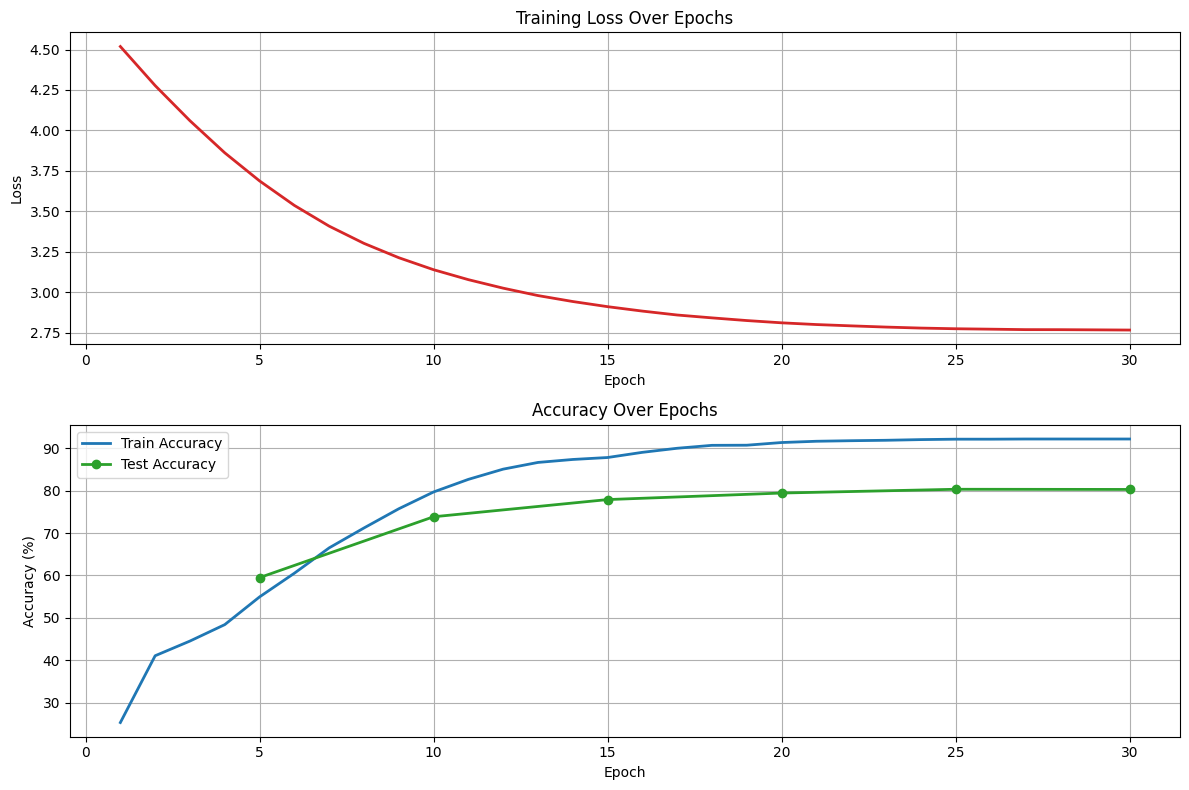

In [28]:
import matplotlib.pyplot as plt

# Data extracted from your training logs
epochs = list(range(1, 31))

losses = [
    4.5189, 4.2772, 4.0599, 3.8615, 3.6878,
    3.5363, 3.4081, 3.3016, 3.2130, 3.1387,
    3.0772, 3.0246, 2.9788, 2.9420, 2.9102,
    2.8828, 2.8586, 2.8409, 2.8243, 2.8103,
    2.7996, 2.7915, 2.7840, 2.7778, 2.7736,
    2.7710, 2.7682, 2.7679, 2.7668, 2.7656
]

train_accs = [
    25.35, 41.09, 44.55, 48.42, 54.95,
    60.53, 66.50, 71.19, 75.71, 79.67,
    82.64, 85.05, 86.63, 87.33, 87.79,
    89.01, 89.97, 90.66, 90.69, 91.32,
    91.62, 91.75, 91.85, 92.01, 92.11,
    92.11, 92.15, 92.15, 92.15, 92.15
]

test_epochs = [5, 10, 15, 20, 25, 30]
test_accs = [59.50, 73.83, 77.88, 79.42, 80.31, 80.27]

# Plotting
plt.figure(figsize=(12, 8))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(epochs, losses, 'tab:red', linewidth=2)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accs, 'tab:blue', label='Train Accuracy', linewidth=2)
plt.plot(test_epochs, test_accs, 'tab:green', marker='o', linestyle='-', linewidth=2, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()